In [ ]:
# https://towardsdatascience.com/beyond-the-cloud-4-visualizations-to-use-instead-of-word-cloud-960dd516f215

+ 목적 : 카테고리/제품별 주요단어 확인
+ 활용 : BI적용을 통한 공유(최근 1달)

In [1]:
import seaborn as sns
import nltk

# import
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import time 
import re
from google.cloud import bigquery
import random
import pymysql
import os 

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
path = 'C:/windows/Fonts/malgun.ttf'                           # 폰트:맑은고딕
font_name = fm.FontProperties(fname=path, size=24).get_name()  
plt.rc('font', family=font_name)

In [2]:
from ckonlpy.tag import Twitter
twitter = Twitter()

c:\Users\khpark\Anaconda3\lib\site-packages\konlpy\tag\_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


JVMNotFoundException: No JVM shared library file (jvm.dll) found. Try setting up the JAVA_HOME environment variable properly.

In [13]:
def listToString(s):  
    str1 = ""  
    for ele in s:  
        str1 += " " + ele.strip()
    return str1

In [60]:
#create function to get a DataFrame
def get_df(input_text):
    list_words = input_text.split(' ')
    set_words_full = list(set(list_words))
    
    #remove stop words
    set_words = [i for i in set_words_full if i not in stop_words]
    
    #count each word
    count_words = [list_words.count(i) for i in set_words]
    
    #create DataFrame
    df = pd.DataFrame(zip(set_words, count_words), columns=['words','count'])
    df.sort_values('count', ascending=False, inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

#create function to get a color dictionary
def get_colordict(palette,number,start):
    pal = list(sns.color_palette(palette=palette, n_colors=number).as_hex())
    color_d = dict(enumerate(pal, start=start))
    return color_d

In [171]:
category_group   = '아몬드'
category_eng     = 'ottmilk'
category_keyword ='브리즈'

In [172]:
#########
# 2.자료 추출 : BigQuery
###

# 접속 정보 
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="C:/Users/MAEIL/OneDrive - 매일유업/auto_send/boxwood-chassis-356100-a2ec31483acb.json"
client = bigquery.Client()

#########
# 자료1 : 키워드 수집현황
###
# 쿼리실행
sql = """SELECT USER
         , FORMAT_DATETIME('%Y-%m-%d', CAST(A.DATE AS DATETIME)) as REG_DTM
         , FORMAT_DATETIME('%Y-%m', CAST(A.DATE AS DATETIME)) as REG_DT
         , FORMAT_DATETIME('%YY-%VW', CAST(A.DATE AS DATETIME)) as REG_WEEK
         , CHANNEL
         , PRODUCT
         , REVIEW
         , SCORE
         FROM `boxwood-chassis-356100.review.review_all` A
         where PRODUCT like '%"""+category_group+"""%'
         and PRODUCT like '%"""+category_keyword+"""%'
         and CAST(A.DATE AS DATETIME) between DATE_SUB(current_date(), INTERVAL 8 DAY) and DATE_SUB(current_date(), INTERVAL 1 DAY)
         order by CAST(A.DATE AS DATETIME) desc"""
df1 = client.query(sql).to_dataframe()
df1 = df1.replace('kakaomakers', '카카오 선물하기')

In [173]:
df1 = df1.replace('어메이징 오트 언스위트 190ml 48팩', '어메이징 오트 [ 언스위트 ] [ 190ML ]')
df1 = df1.replace('어메이징 오트 언스위트 190ml 24팩', '어메이징 오트 [ 언스위트 ] [ 190ML ]')
df1 = df1.replace('어메이징 오트 오리지널 190ml 24팩', '어메이징 오트 [ 오리지널 ] [ 190ML ]')
df1 = df1.replace('어메이징 오트 오리지널 190ml 48팩', '어메이징 오트 [ 오리지널 ] [ 190ML ]')
df1 = df1.replace('매일유업 어메이징 오트 190ml x 24팩 (오리지널/언스위트)', '어메이징 오트 [ 오리지널 ] [ 190ML ]')
df1 = df1.replace('[매일유업] 어메이징 오트 오리지널 / 언스위트 190ml 24팩', '어메이징 오트 [ 언스위트 ] [ 190ML ],어메이징 오트 [ 오리지널 ] [ 190ML ]')
df1 = df1.replace('매일 두유 6종 / (신제품)어메이징오트 2종 190ml 24팩 택1', '매일 두유 6종 / 어메이징오트 2종 190ml 24팩 택1')

df1 = df1.replace('매일유업 어메이징 오트 바리스타 950ml 3팩',         '어메이징 오트 [ 바리스타 ] [ 950ML ]')
df1 = df1.replace('[매일유업] 어메이징오트 바리스타 950ml x 3팩',      '어메이징 오트 [ 바리스타 ] [ 950ML ]')
df1 = df1.replace('매일유업 어메이징 오트 언스위트 두유, 24개, 190ml', '어메이징 오트 [ 언스위트 ] [ 190ML ]')
df1 = df1.replace('매일유업 어메이징 오트 오리지널 두유, 24개, 190ml', '어메이징 오트 [ 오리지널 ] [ 190ML ]')

df1 = df1.replace('선택: 어메이징 오트 오리지널', '어메이징 오트 [ 오리지널 ] [ 190ML ]')
df1 = df1.replace('(대용량) 아몬드브리즈/매일두유/어메이징오트 950ml x 10팩', '어메이징 오트 [ 바리스타 ] [ 950ML ]')

In [174]:
df1.REG_DTM.max()

'2022-07-24'

In [175]:
###############
# 2.자료 추출 : MySQL
#####
# 접속 정보 
conn = pymysql.connect(host = '**.***.*.*', user ='__USER__', password = "__PASSWORD__", database='__DATABASE__')
cursor = conn.cursor(pymysql.cursors.DictCursor)

# 쿼리실행: 전체리뷰
sql= '''select A.WRITER as USER
        , (STR_TO_DATE(A.WRITE_DT, '%Y%m%d'))  as REG_DTM 
        , left((STR_TO_DATE(A.WRITE_DT, '%Y%m%d')),7)  as REG_DT 
        , DATE_FORMAT(STR_TO_DATE(A.WRITE_DT, '%Y%m%d'),'%YY-%uW' )  as REG_WEEK 
        , (SELECT CODE_NM FROM JT_CODE B WHERE A.COMPANY_CODE = B.CODE AND B.CODE_GRP_ID = 'DEALER_ID') as CHANNEL 
        , B.CODE_NM as PRODUCT
        , A.GRADE as SCORE
        , trim(A.CONTENTS) as REVIEW
        FROM MAEIL_REVIEW A, JT_CODE B
        where A.GRADE in (1,2,3,4,5)
        and CAST(STR_TO_DATE(A.WRITE_DT, '%Y%m%d') AS DATETIME) between DATE_SUB(current_date(), INTERVAL 8 DAY) and DATE_SUB(current_date(), INTERVAL 1 DAY)
        and A.PRODUCT_CODE = B.CODE 
        AND B.CODE_NM like '%'''+category_group +'''%'
        AND B.CODE_NM like '%'''+category_keyword +'''%'
        and B.CODE not like'G_%'
        order by A.WRITE_DT desc
        '''
cursor.execute(sql)
df2 = cursor.fetchall()
df2 = pd.DataFrame(df2)

df2 = df2.replace('25 카카오 톡스토어(20.12.2~미사용)', '25 카카오톡')

In [176]:
df2.REG_DTM.max()

datetime.date(2022, 7, 25)

In [177]:
df1.PRODUCT.unique()

array(['아몬드브리즈 프로틴  190ml 24팩', '아몬드브리즈 오리지널 190ml 24팩',
       '아몬드브리즈 언스위트 190ml 24팩', '아몬드브리즈 초콜릿 190ml 24팩',
       '아몬드브리즈 식이섬유  190ml 24팩', '아몬드브리즈 바나나  190ml 24팩'], dtype=object)

In [178]:
df = pd.concat([df1, df2], ignore_index=True)
df['REG_DTM'] = pd.to_datetime(df['REG_DTM'],format = '%Y-%m-%d')
# df['REG_DTM'] = df['REG_DTM']
df.PRODUCT = df.PRODUCT.str.lower() 
df['SCORE'] = df['SCORE'].astype(float)
df['REVIEW'] = df['REVIEW'].str.replace('\n', ' ')
df['lenght'] = df['REVIEW'].str.len()

df = df[df.lenght != 0]
df = df.reset_index(drop=True)

In [179]:
df.tail(2)

,USER,REG_DTM,REG_DT,REG_WEEK,CHANNEL,PRODUCT,REVIEW,SCORE,lenght
1986,gp****,2022-07-18,2022-07,2022Y-29W,3 네이버,멸균 아몬드브리즈 [ 식이섬유 ] [ 190ml ],배송 빠르고 좋아요!!,5.0,12
1987,mine******,2022-07-18,2022-07,2022Y-29W,3 네이버,멸균 아몬드브리즈 [ 식이섬유 ] [ 190ml ],매일 한개씩 운동전에 먹고있어요~ 은근히 든든하고 좋아요,5.0,31


In [180]:
df.PRODUCT.unique()

array(['아몬드브리즈 프로틴  190ml 24팩', '아몬드브리즈 오리지널 190ml 24팩',
       '아몬드브리즈 언스위트 190ml 24팩', '아몬드브리즈 초콜릿 190ml 24팩',
       '아몬드브리즈 식이섬유  190ml 24팩', '아몬드브리즈 바나나  190ml 24팩',
       '멸균 아몬드브리즈 [ 오리지널 ] [ 190ml ]', '멸균 아몬드브리즈 [ 프로틴 ] [ 190ml ]',
       '멸균 아몬드브리즈 [ 식이섬유 ] [ 190ml ]', '멸균 아몬드브리즈 [ 오리지널 ] [ 950ml ]',
       '멸균 아몬드브리즈 [ 언스위트 ] [ 190ml ]', '멸균 아몬드브리즈 [ 언스위트 ] [ 950ml ]',
       '멸균 아몬드브리즈 [ 초콜릿 ] [ 190ml ]', '멸균 아몬드브리즈 [ 바나나 ] [ 190ml ]'],
      dtype=object)

In [146]:
df.CHANNEL.unique()

array(['G마켓', '카카오 선물하기', '카카오 쇼핑하기', '3 네이버'], dtype=object)

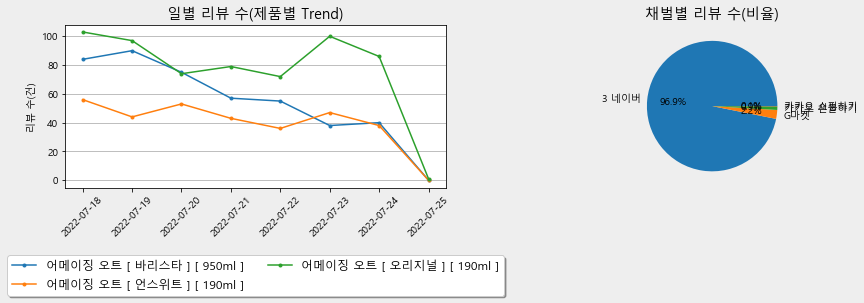

In [155]:
######################
# 관련값 계산
##########

# 제품별 리뷰건 수
df_sub1 = pd.pivot_table(df, values='REVIEW', index=['REG_DTM'],columns=['PRODUCT'],  aggfunc='count').fillna(0)

# 체널 비중
df_sub2 = df.groupby('CHANNEL')['USER'].count()


fig = plt.figure(figsize=(15, 3), facecolor='#eeeeee' )

# 그래프1 : 채널별 
ax1 = plt.subplot(1,2,1)
# plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.5)
plt.plot(df_sub1,'.-',  label=df_sub1.columns )
ax1.legend(list(df_sub1.columns), loc='lower center', bbox_to_anchor=(0.5, -0.7), fancybox=True, shadow=True, ncol=2,fontsize='large')
plt.grid(True, axis='y')
plt.xticks(rotation=45)
plt.title('일별 리뷰 수(제품별 Trend)',fontsize='x-large')
plt.ylabel('리뷰 수(건)')

ax2 = plt.subplot(1,2,2)
plt.pie(df_sub2, labels=df_sub2.index, autopct='%.1f%%')
plt.title('채벌별 리뷰 수(비율)',fontsize='x-large')

plt.show()

In [156]:
# tokenized_doc

In [160]:
stop_words = ['은', '는', '', '잘', '너무', '어요', '요', '먹', '좋', '했', '합니다', '어서', '아해', '샀', 
              '개', '달', '진', '때', '있', '재', '감사', '하게', '하나', '더', '들이', '것', '할', '늘', '굿',
              '또', '다', '넘', '후', '수', '딱', '또', '이', '덜', '좀', '전', '려고', '들', '제', '거', '고', 
              '담', '데', '구', '안', '입니다', '타', '같아요', '항상', '생각', '깔', '저', '하니', '했는데', '어도',
              '않고', '오리', '정말', '다가', 
             ] 

In [168]:
text_c = listToString(df.REVIEW)
tokenized_doc = twitter.pos(text_c)
tokenized_nouns = ' '.join([word[0] for word in tokenized_doc if (word[1] == 'Noun') | (word[1] == 'Verb') | (word[1] == 'Adjective')])
df_words = get_df(tokenized_nouns)
# df_words = df_words.head(30)

In [169]:
# df_words

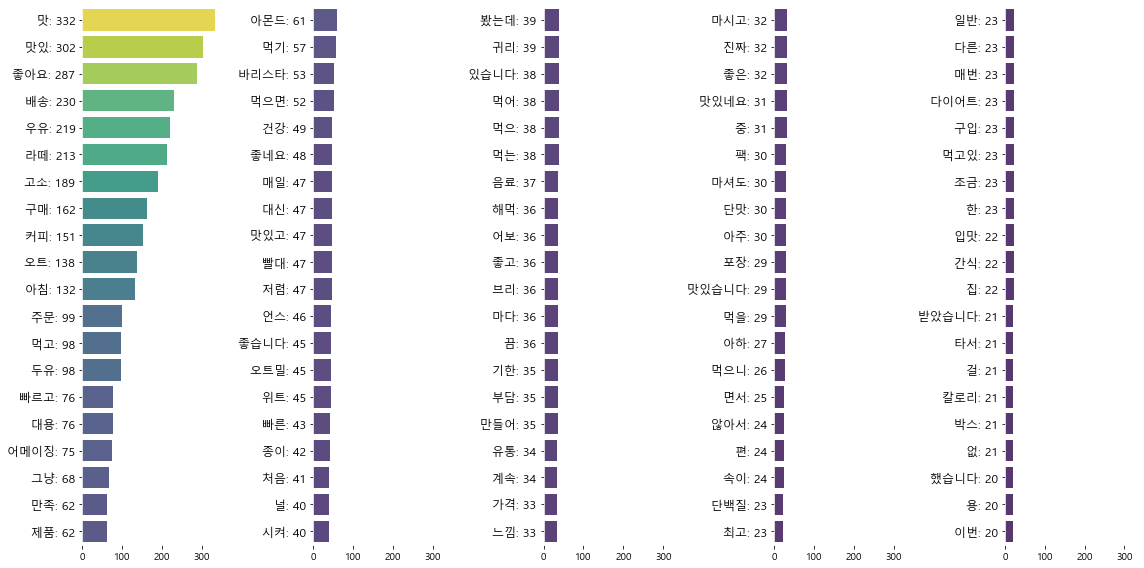

In [170]:
#create index list for slicing
index_list = [[i[0],i[-1]+1] for i in np.array_split(range(100), 5)]

n = df_words['count'].max()
color_dict = get_colordict('viridis', n, 1)

fig, axs = plt.subplots(1, 5, figsize=(16,8), facecolor='white', squeeze=False)
for col, idx in zip(range(0,5), index_list):
    df_tepm = df_words[idx[0]:idx[-1]]
    label = [w + ': ' + str(n) for w,n in zip(df_tepm['words'],df_tepm['count'])]
    color_l = [color_dict.get(i) for i in df_tepm['count']]
    x = list(df_tepm['count'])
    y = list(range(0,20))
    
    sns.barplot(x = x, y = y, data=df_tepm, alpha=0.9, orient = 'h',
                ax = axs[0][col], palette = color_l)
    axs[0][col].set_xlim(0,n+1)                     #set X axis range max
    axs[0][col].set_yticklabels(label, fontsize=12)
    axs[0][col].spines['bottom'].set_color('white')
    axs[0][col].spines['right'].set_color('white')
    axs[0][col].spines['top'].set_color('white')
    axs[0][col].spines['left'].set_color('white')
            
plt.tight_layout()    
plt.show()